# CNN using Keras in TensorFlow

This notebook shows an example of training and
testing a multi-class CNN model on the classic
MNIST image set. We use the keras portion of
TensorFlow to do this.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

# Print out the TensorFlow version to help others reproduce this notebook.
print(tf.__version__)

1.9.0


## Load in the data

Each input is a black and white (single channel)
image of size 28x28. Each label (y-value) is an integer from 0 to 9.

Each pixel has type `uint8`; an integer in the range [0, 256).

This data format is explored and explained in a bit more detail
in the notebook for Koan 4.

In [2]:
mnist = keras.datasets.mnist

(X_train_, y_train_), (X_test_, y_test_) = mnist.load_data()

### Convert the data format

The multi-class categorical loss functions built-in to keras expect
the labels to be one-hot vectors. We perform the corresponding
conversion using numpy alone;
another approach would be to use keras'
[`to_categorical()`](https://keras.io/utils/#to_categorical) function.

In [4]:
# Convert the labels to one-hot vectors.
y_train = np.eye(10)[y_train_]
y_test  = np.eye(10)[y_test_]

# Sanity check.
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [5]:
# Convert the images to have a (size-1) channel dimension.

def add_channel_dim(arr):
    return arr.reshape(arr.shape + (1,))

X_train = add_channel_dim(X_train_)
X_test  = add_channel_dim(X_test_)

## Set up the keras model

As far as CNNs go, this one is relatively simple.
It essentially consists of 2 convolution-max-pool groups followed by
a single fully-connected hidden layer, and ending with a 10-output
softmax layer.

This is similar to the model found in
[this keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py),
although this model has no regularization (and doesn't seem to suffer much
without it).

In [14]:
layers = keras.layers

model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(
    optimizer = tf.train.AdamOptimizer(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

In [24]:
# Review a summary of the model we've designed.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total para

In [15]:
# Train the model.

history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 33s 690us/step - loss: 2.5745 - categorical_accuracy: 0.7950 - val_loss: 0.2144 - val_categorical_accuracy: 0.9568
Epoch 2/10
48000/48000 [==============================] - 34s 703us/step - loss: 0.1537 - categorical_accuracy: 0.9652 - val_loss: 0.1215 - val_categorical_accuracy: 0.9728
Epoch 3/10
48000/48000 [==============================] - 35s 724us/step - loss: 0.0800 - categorical_accuracy: 0.9788 - val_loss: 0.0995 - val_categorical_accuracy: 0.9756
Epoch 4/10
48000/48000 [==============================] - 34s 707us/step - loss: 0.0549 - categorical_accuracy: 0.9849 - val_loss: 0.0828 - val_categorical_accuracy: 0.9798
Epoch 5/10
48000/48000 [==============================] - 34s 714us/step - loss: 0.0379 - categorical_accuracy: 0.9885 - val_loss: 0.0936 - val_categorical_accuracy: 0.9792
Epoch 6/10
48000/48000 [==============================] - 36s 752us/step - loss: 0.02

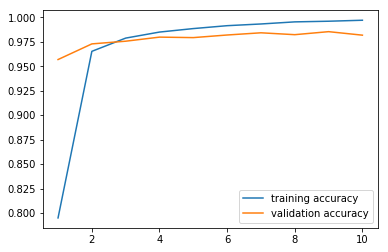

In [23]:
# Plot the training and validation accuracy over time.

epochs = range(1, 11)

plt.plot(epochs, history.history['categorical_accuracy'], label='training accuracy')
plt.plot(epochs, history.history['val_categorical_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Compute the test-set accuracy

In [25]:
results = model.evaluate(X_test, y_test)

print()
print('Test accuracy:')
print(results[1])

10000/10000 [==============================] - 2s 204us/step

Test accuracy:
0.9813


## Examine some mistakes made

It can be instructive to take a look at errors
the model makes. We'll get the indexes of all
the errors on the test set, and take a look at
a random subset of these.

In [26]:
# Find all the places in the test set where the model
# predicts the wrong class. The boolean != operator here
# results in an array of True/False values, and the
# np.flatnonzero() call converts that to the indexes
# where the value is True.

predicted_classes = model.predict_classes(X_test)

mistakes = np.flatnonzero(predicted_classes != y_test_)
len(mistakes)

187

In [27]:
# Choose a random subset of mistakes that we'll display.

nrows, ncols = 2, 4

show_idx = np.random.choice(
    np.arange(len(mistakes)),
    size = nrows * ncols,
    replace = False
)
show_idx = mistakes[show_idx]

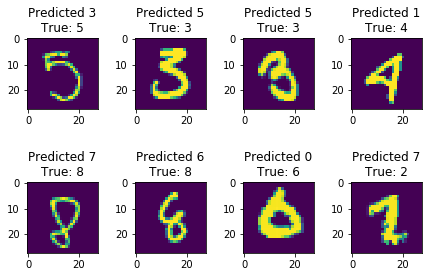

In [29]:
# Render and label the random mistakes.

plt.subplots(nrows, ncols)
plt.tight_layout(pad=0.0)

for i, pt_idx in enumerate(show_idx):
    
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(X_test_[pt_idx])
    fmt = 'Predicted %d\nTrue: %d'
    title = fmt % (predicted_classes[pt_idx], y_test_[pt_idx])
    plt.title(title)
    
plt.show()

I find some of these mistakes understandable,
and others less so. For example, the large
6 digit is visually extremely close to a 0.
As a human, I would be uncertain about the correct
label. Likewise with the 2 that looks like a 7.
However, I find most of the other images to be
clear to me as a human. I have a sense that the
model has missed something fundamental about the
topology of a figure-8 that makes it confused about
those images, and I wonder what sort of model may
be better at capturing that kind of information.

# Summary

So far among these koans, we have the following test accuracies for
the MNIST dataset:

* Multi-class SVM: 89.05%
* Basic CNN (here): 98.13%

This model is doing a much better job.

(You may see a slightly different value on your run since
models are randomly initialized each time.)